<a href="https://colab.research.google.com/github/SvgPrizrak/ML_Sber_Homework/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22hw04_clustering%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ4. Кластеризация

## 1. Получение и подготовка данных

Вам предлагается сделать кластеризацию объектов датасете вин - https://www.openml.org/d/187.

Скачаем датасет, подставьте ссылку на скачивание датасета в ячейку ниже:

In [ ]:
!wget https://www.openml.org/d/187

--2023-12-13 14:24:26--  https://www.openml.org/d/187
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://www.openml.org/search?type=data&sort=runs&id=187 [following]
--2023-12-13 14:24:27--  https://www.openml.org/search?type=data&sort=runs&id=187
Reusing existing connection to www.openml.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 682 [text/html]
Saving to: ‘187.7’

187.7               100%[===================>]     682  --.-KB/s    in 0s      

2023-12-13 14:24:27 (190 MB/s) - ‘187.7’ saved [682/682]



In [ ]:
# по какой-то причине предложенный изначально в задании вариант получения данных не заработал - можно использовать документацию openml
!pip install openml
import openml
openml.datasets.list_datasets(output_format="dataframe")
dataset = openml.datasets.get_dataset(187)
df_data, _, _, _  = dataset.get_data(dataset_format="dataframe")

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
# from scipy.io.arff import loadarff

# raw_data = loadarff('https://api.openml.org/data/v1/download/3624/wine.arff')
# df_data = pd.DataFrame(raw_data[0])
# df_data.head()

Видим пару проблем с данными:
- колонка `class` содержит в себе не числа, а бинарные строки - нужно поменять тип данных в колонке

In [ ]:
# Ваш код
df_data['class'] = df_data['class'].astype('str')

In [ ]:
df_data.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


- колонка после `hue` имеет нехорошее имя - надо исправить на `OD280_to_OD315_of_diluted_wines`:

In [ ]:
# Ваш код
df_data.rename({'OD280%2FOD315_of_diluted_wines': 'OD280_to_OD315_of_diluted_wines'}, axis=1, inplace=True)

In [ ]:
df_data.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_to_OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Теперь остается разбить данные на матрицу признаков `X` и целевые классы `y` (их будем использовать при оценке качества):

In [ ]:
# Ваш код
X, y = df_data.drop('class', axis=1), df_data['class']

## 2. Метрики качества

Вам необходимо реализовать 1 внешнюю и 1 внутреннюю метрику качества.

**Внешние метрики** качества используют для оценки результатов модели полученные метки кластеров И некоторую дополнительную информацию о распределении (например, метки классов).

[Внешние метрики качества](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.92.D0.BD.D0.B5.D1.88.D0.BD.D0.B8.D0.B5_.D0.BC.D0.B5.D1.80.D1.8B_.D0.BE.D1.86.D0.B5.D0.BD.D0.BA.D0.B8_.D0.BA.D0.B0.D1.87.D0.B5.D1.81.D1.82.D0.B2.D0.B0):
- [Индекс Rand](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.98.D0.BD.D0.B4.D0.B5.D0.BA.D1.81_Rand)
- [Индекс Жаккара](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.98.D0.BD.D0.B4.D0.B5.D0.BA.D1.81_.D0.96.D0.B0.D0.BA.D0.BA.D0.B0.D1.80.D0.B0_.28.D0.B0.D0.BD.D0.B3.D0.BB._Jaccard_Index.29)
- [F-мера](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#F-.D0.BC.D0.B5.D1.80.D0.B0)

In [ ]:
def outer_metric(actual_values: pd.Series, pred_values: pd.Series):

    """
    Функция реализации метрики Rand Index:

    Args:
    * actual_values - pd.Series с истинными значениями;
    * pred_values - pd.Series с предсказанными значениями;

    Returns:
    * значене метрики Rand Index
    """

    # вычислим все нужные нам основы метрик - TP, FP, TN, FN
    tp_plus_fp = comb(np.bincount(actual_values), 2).sum()
    tp_plus_fn = comb(np.bincount(pred_values), 2).sum()
    A = np.c_[(actual_values, pred_values)]
    true_positive = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(actual_values))
    false_positive = tp_plus_fp - true_positive
    false_negative = tp_plus_fn - true_positive
    true_negative = comb(len(A), 2) - true_positive - false_positive - false_negative

    # получение значения rand index
    return (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)

In [ ]:
# можно сравнить полученные значения метрик, написанные вручную и через sklearn - значения совпадают
from sklearn import metrics
print(metrics.rand_score(labels_true=[0, 0, 1, 1, 1, 1, 0, 0, 0, 1], labels_pred=[0, 1 ,0, 1, 0, 1, 0, 1, 1, 1]))
print(outer_metric(actual_values=[0, 0, 1, 1, 1, 1, 0, 0, 0, 1], pred_values=[0, 1 ,0, 1, 0, 1, 0, 1, 1, 1]))

0.4444444444444444
0.4444444444444444


**Внутренние метрики** качества используют для оценки результатов модели только полученные метки кластеров.

[Внутренние метрики качества](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.92.D0.BD.D1.83.D1.82.D1.80.D0.B5.D0.BD.D0.BD.D0.B8.D0.B5_.D0.BC.D0.B5.D1.80.D1.8B_.D0.BE.D1.86.D0.B5.D0.BD.D0.BA.D0.B8_.D0.BA.D0.B0.D1.87.D0.B5.D1.81.D1.82.D0.B2.D0.B0):
- [Силуэтный индекс](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.A1.D0.B8.D0.BB.D1.83.D1.8D.D1.82_.28.D0.B0.D0.BD.D0.B3.D0.BB._Silhouette.29)
- [Индекс Calinski-Harabasz](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.98.D0.BD.D0.B4.D0.B5.D0.BA.D1.81_Calinski.E2.80.93Harabasz)
- [Индекс Dunn](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.98.D0.BD.D0.B4.D0.B5.D0.BA.D1.81_.D0.94.D0.B0.D0.BD.D0.BD.D0.B0_.28.D0.B0.D0.BD.D0.B3.D0.BB._Dunn_Index.29)


In [ ]:
def inner_metric(data: pd.DataFrame, labels: pd.Series):

    """
    Функция реализации метрики Calinski-Harabasz для кластеризации (частично помог ChatGPT)

    Args:
    * data - датафрейм с входными признаками
    * labels - полученные метки для кластеризации (номера кластеров)

    Returns:
    ch_index - значение Calinski-Harabasz Index
    """

    # количество точек
    num_points = len(data)

    # количество кластеров
    num_clusters = len(np.unique(labels))

    # расчет центроидов для каждого кластера
    centroids = np.array([np.mean(data[labels == str(i)], axis=0) for i in range(1, num_clusters + 1)])

    # расчет центроидов для всех данных
    overall_centroid = np.array(np.mean(data, axis=0))

    # расчет дисперсии между кластерами
    between_variance = sum(np.sum((centroids[i-1] - overall_centroid)**2) * np.sum(labels == str(i)) for i in range(1, num_clusters + 1))

    # расчет дисперсии внутри кластера
    within_variance = sum([np.sum(np.square(np.linalg.norm(data[labels == str(i)] - centroids[i-1], axis=1))) for i in range(1, num_clusters + 1)])

    # расчет индекса Calinski-Harabasz
    ch_index = (between_variance / (num_clusters - 1)) / (within_variance / (num_points - num_clusters))

    return ch_index

In [ ]:
# можно сравнить полученные значения метрик, написанные вручную и через sklearn - значения совпадают
print(metrics.calinski_harabasz_score(X, y))
print(inner_metric(X, y))

206.6781164482878
206.67811644828777


## 3. Обучение модели и подбор гиперпараметров

Вам необходимо:
- выбрать одну из нижеуказанных моделей кластеризации
- обучить ее для разных значений гиперпараметра
- построить график зависимости реализованных Вами метрик качества от значения гиперпараметра

Модели кластеризации и их гиперпараметр:
- **K-Means** - количество кластеров $k$
- **DBSCAN** - радиус окрестности $\varepsilon$
- **Agglomerative Clustering** - количество кластеров $k$



Сколько взять значений гиперпараметров, какие брать значения гиперпараметров - это уже нужно решить вам, в этом и заключается ваша аналитическая работа :)

In [ ]:
# Ваш код - в качестве модели выберем KMeans
from sklearn.cluster import KMeans

In [ ]:
# в качестве гиперпараметра выберем количество кластеров - слишком большое количество нет смысла брать, ибо будут слишком маленькие кластеры - и внутренняя метрика будет нерепрезентативна
n_clusters_list = np.arange(2, 20, 1)

# также сделаем списки для внешних и внутренних метрик
outer_metric_list, inner_metric_list = [], []

# реализация цикла для построения графиков (lambda x: x+1, потому что в датасете label отсчитывается от 1, а в clustering.labels_ с 0)
for i_cluster in n_clusters_list:
    clustering = KMeans(n_clusters=i_cluster, init='k-means++', n_init='auto', random_state=4).fit(X)
    outer_metric_list.append(outer_metric(actual_values=list(map(int, y)), pred_values=list(map(lambda x: x+1, clustering.labels_))))

    # реализованная мной метрика
    inner_metric_list.append(inner_metric(X, pd.Series(map(lambda x: x+1, clustering.labels_)).astype('str')))

    # метрика из sklearn - для сравнения графиков, проверка верности реализации метрики
    # inner_metric_list.append(metrics.calinski_harabasz_score(X, pd.Series(map(lambda x: x+1, clustering.labels_)).astype('str')))

    # также можно посмотреть, что покажет другая метрика - Силуэтный индекс (просто ради интереса)
    # inner_metric_list.append(metrics.silhouette_score(X, pd.Series(map(lambda x: x+1, clustering.labels_)).astype('str')))

    # можно добавить предсказанные классы в датасет для построения графиков
    df_data[f'pred_{i_cluster}_clusters_class'] = pd.Series(map(lambda x: x+1, clustering.labels_)).astype('str')

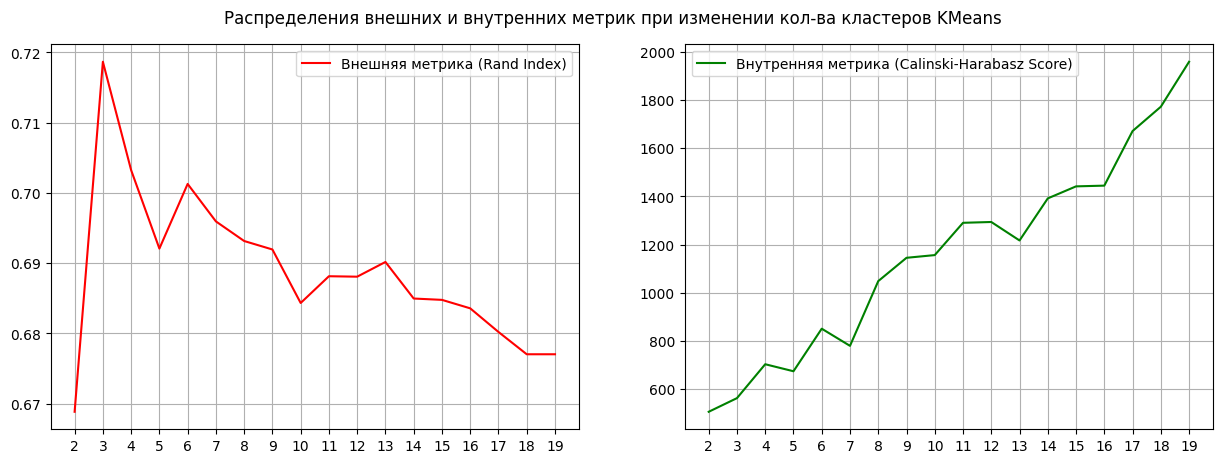

In [ ]:
# видно расхождения во внутренней метрике - по внешней метрике количество кластеров следует брать равное 3
# можно проверить, убрав комментарий в строке кода в ячейке выше - значения метрик будут совпадать
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Распределения внешних и внутренних метрик при изменении кол-ва кластеров KMeans', size=12, y=0.95)
ax[0].plot(n_clusters_list, outer_metric_list, color='red', label='Внешняя метрика (Rand Index)')
ax[1].plot(n_clusters_list, inner_metric_list, color='green', label='Внутренняя метрика (Calinski-Harabasz Score)')

for i in range(2):
    ax[i].set_xticks(n_clusters_list)
    ax[i].grid()
    ax[i].legend()
plt.show()

А что же с внутренней метрикой? Здесь все сложнее: с одной стороны, чем выше значение метрики, тем кластеры лучше определены (согласно документации sklearn), однако сама метрика очень сильно зависит от `random_state` + есть точки локальных минимумов функции. Можно попробовать посмотреть количество кластеров от 3-4 (посмотрев на нынешние внешние и внутренние метрики и построив графики в `seaborn`).

In [ ]:
# код для построения графика (просто для просмотра)
import seaborn as sns
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
for_graph_df = pd.DataFrame(pca.fit_transform(X), columns = ['x', 'y'])
for i in range(3, 10):
    for_graph_df[f'pred_{i}_clusters_class'] = df_data[f'pred_{i}_clusters_class']
for_graph_df

,x,y,pred_3_clusters_class,pred_4_clusters_class,pred_5_clusters_class,pred_6_clusters_class,pred_7_clusters_class,pred_8_clusters_class,pred_9_clusters_class
0,318.562979,21.492131,2,2,2,2,7,2,2
1,303.097420,-5.364718,2,2,2,2,7,2,2
2,438.061133,-6.537309,2,4,4,2,7,8,8
3,733.240139,0.192729,2,4,4,4,4,7,7
4,-11.571428,18.489995,3,3,3,3,6,3,5
...,...,...,...,...,...,...,...,...,...
173,-6.980211,-4.541137,3,3,3,3,6,3,5
174,3.131605,2.335191,3,3,3,6,6,5,5
175,88.458074,18.776285,3,2,2,6,6,5,9
176,93.456242,18.670819,3,2,2,6,6,5,9


<Axes: xlabel='x', ylabel='y'>

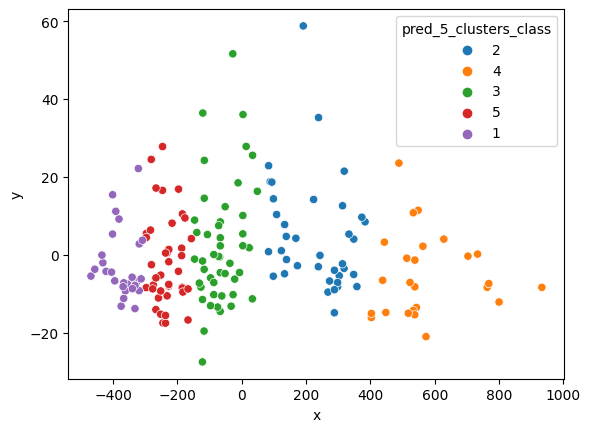

In [ ]:
# справедливости ради даже 5-7 кластеров выглядят вполне адекватно, несмотря на наличие выбросов, а много кластеров уже ведут к вычислительной нагрузке
sns.scatterplot(data=for_graph_df, x='x', y='y', hue='pred_5_clusters_class')